In [22]:
##initial imports

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import pickle
import urllib2


In [23]:
##this code scrapes two web pages from footballoutsiders, and uses nested loops to iterate through 14 seasons
##the output is a pandas dataframe for each page, with various statistics which may become potential features 
##in the model

import csv
from bs4 import BeautifulSoup
from urllib2 import urlopen
link = 'http://www.footballoutsiders.com/stats/drivestatsoff'
link2 = 'http://www.footballoutsiders.com/stats/teameff'
empty = []
dfOff = pd.DataFrame(empty)
dfEff = pd.DataFrame(empty)
year = ['2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015']
for yr in year:
    url = link+yr
    url2 = link2+yr
    soup = BeautifulSoup(urlopen(url))
    soup2 = BeautifulSoup(urlopen(url2))
    table = soup.find('table', attrs={ "class" : "stats"})
    table2 = soup2.find('table', attrs={ "class" : "stats"})
    rows = []
    rows2 = []

    for row in table.find_all('tr'):
        rows.append([val.text.encode('utf8') for val in row.find_all('td')])

    
    for row2 in table2.find_all('tr'):
        rows2.append([val.text.encode('utf8') for val in row2.find_all('td')])
    
    tempstr = ''
    tempstr2 = ''
    seasonTable = []
    seasonTable2 = []
    t = []
    t2 = []
    
    for row in rows:
        for item in row:
            for subitem in item:
                if subitem == ' ':
                    break
                else:
                    tempstr = tempstr + subitem
            t.append(tempstr)
            tempstr = ''
        seasonTable.append(t)
        t = []
        
    for row2 in rows2:
        for item2 in row2:
            for subitem2 in item2:
                if subitem2 == ' ':
                    break
                else:
                    tempstr2 = tempstr2 + subitem2
            t2.append(tempstr2)
            tempstr2 = ''
        seasonTable2.append(t2)
        t2 = []
        
    
    df = pd.DataFrame(seasonTable)
    df2 = pd.DataFrame(seasonTable2)
    df['season'] = yr
    df2['season'] = yr
    dfOff = dfOff.append(df)
    dfEff = dfEff.append(df2)


In [24]:
##cleaning up the dataframes
dfOff.columns=['Team','Drives','Yds_Dr','Pts_Dr','TOs_Dr','INT_Dr','FUM_Dr','LOS_Dr','Plays_Dr','TOP_Dr','DSR','Season']

dfEff.columns=['na','Team','TotalDVOA','LastYr','NonAdjTot','W-L','OffDVOA','OffRank','DefDVOA','DefRank','STDDVOA','STRank','Season']

dfOff = dfOff[dfOff.Team != 'Team']
dfOff = dfOff[dfOff.Team != 'Avg']

dfEff = dfEff[dfEff.Team != '\nTEAM\n']
del dfEff['na']


In [26]:
##merging the two dataframes

dfOff.reset_index(inplace=True)
dfEff.reset_index(inplace=True)
dfMerged = pd.merge(dfOff, dfEff,
              left_on=['Team', 'Season'],
              right_on=['Team', 'Season'],
              how='inner')

In [27]:
##more dataframe cleanup

del dfMerged['index_x']
del dfMerged['index_y']

In [28]:
##creating a copy just in case

dfcopy = dfMerged


In [29]:
##eliminating redundant/unnecessary features

dfMerged = dfMerged.drop(['INT_Dr','FUM_Dr','TOP_Dr','LastYr','STRank'], axis=1)

In [30]:
#setting the columns to drop to create a subdataframe, "pwins"

columns = dfMerged.columns
columnsinv = []
for item in columns:
    if item == 'Team':
        pass
    elif item == "Season":
        pass
    else:
        columnsinv.append(item)

pwins = dfMerged.drop(columnsinv, axis=1)

In [32]:
## lists for each season from 2002 to 2015 with all of the teams who made the playoffs
## ordered based on where they finished

o2 = ['GB','NYG','IND','CLE','SF','ATL','NYJ','PIT','PHI','TEN','OAK','TB']
o3 = ['DAL','SEA','DEN','BAL','STL','GB','KC','TEN','PHI','IND','CAR','NE']
o4 = ['DEN','SD','SEA','GB','IND','NYJ','STL','MIN','PIT','ATL','PHI','NE']
o5 = ['NYG','TB','CIN','JAC','CHI','WAS','IND','NE','CAR','DEN','SEA','PIT']
o6 = ['NYG','KC','NYJ','DAL','SD','BAL','PHI','SEA','NE','NO','CHI','IND']
o7 = ['TB','WAS','TEN','PIT','DAL','SEA','IND','JAC','GB','SD','NE','NYG']
o8 = ['MIA','IND','MIN','ATL','TEN','SD','NYG','CAR','PHI','BAL','ARI','PIT']
o9 = ['PHI','GB','CIN','NE','DAL','ARI','SD','BAL','MIN','NYJ','IND','NO']
ten = ['IND','KC','PHI','NO','NE','BAL','ATL','SEA','NYJ','CHI','PIT','GB']
eleven = ['CIN','PIT','ATL','DET','HOU','DEN','GB','NO','BAL','SF','NE','NYG']
twelve = ['IND','CIN','MIN','WAS','DEN','HOU','GB','SEA','NE','ATL','SF','BAL']
thirteen = ['GB','PHI','KC','CIN','CAR','NO','IND','SD','SF','NE','SEA','DEN']
fourteen = ['CIN','PIT','DET','ARI','DEN','BAL','DAL','CAR','IND','GB','NE','SEA']
fifteen = ['WAS','MIN','HOU','CIN','GB','SEA','KC','PIT','ARI','NE','CAR','DEN']
seasons = [o2,o3,o4,o5,o6,o7,o8,o9,ten,eleven,twelve,thirteen,fourteen,fifteen]
points = [1,1,1,1,2,2,2,2,3,3,4,5]
master = []

In [33]:
#small script generating a dataframe 'p' which has all the info on playoff finishes per team from 2002-2015

count = 0
for season in seasons:
    i = 2002
    y = [str(i+count)]*12
    l = zip(season,y,points)
    for item in l:
        master.append(list(item))
    count = count+1
    
p = pd.DataFrame(master)

In [35]:
## setting column names
p.columns = ['Team','Season','PlayoffRound']

In [37]:
## merging the subdataframes to create a df containing the playoff finish per team (0-5) for each of the
## 32 teams in each of the past 14 seasons

pmerge = pd.merge(pwins, p,
              left_on=['Team', 'Season'],
              right_on=['Team', 'Season'],
              how='outer')


In [38]:
##replacing the NaN values with 0's 
pmerge = pmerge.fillna(0)

In [125]:
##creating the final master dataframe

final = pd.merge(dfMerged, pmerge,
              left_on=['Team', 'Season'],
              right_on=['Team', 'Season'],
              how='inner')


In [127]:
##maintenance on the final dataframe, converting percents to floats and swapping the w-l column for a "wins" column

import re

final['TotalDVOA'] = final['TotalDVOA'].map(lambda x: float(x.strip('%'))/100,
               na_action=None)
final['NonAdjTot'] = final['NonAdjTot'].map(lambda x: float(x.strip('%'))/100,
               na_action=None)
final['OffDVOA'] = final['OffDVOA'].map(lambda x: float(x.strip('%'))/100,
               na_action=None)
final['DefDVOA'] = final['DefDVOA'].map(lambda x: float(x.strip('%'))/100,
               na_action=None)
final['STDDVOA'] = final['STDDVOA'].map(lambda x: float(x.strip('%'))/100,
               na_action=None)
final['W-L'] = final['W-L'].map(lambda x: re.sub(r'\-.*','',x),
               na_action=None)
final['Wins'] = final['W-L']
final = final.drop('W-L',axis=1)

In [128]:
##setting the datatypes to floats and ints

final.Drives = final.Drives.astype(float)
final.Yds_Dr = final.Yds_Dr.astype(float)
final.Pts_Dr = final.Pts_Dr.astype(float)
final.TOs_Dr = final.TOs_Dr.astype(float)
final.LOS_Dr = final.LOS_Dr.astype(float)
final.Plays_Dr = final.Plays_Dr.astype(float)
final.DSR = final.DSR.astype(float)
final.Season = final.Season.astype(int)
final.TotalDVOA = final.TotalDVOA.astype(float)
final.NonAdjTot = final.NonAdjTot.astype(float)
final.OffDVOA = final.OffDVOA.astype(float)
final.OffRank = final.OffRank.astype(int)
final.DefDVOA = final.DefDVOA.astype(float)
final.DefRank = final.DefRank.astype(int)
final.STDDVOA = final.STDDVOA.astype(float)
final.Wins = final.Wins.astype(int)


In [129]:
##random copypasted imports because I"m too lazy to check if I had them all

import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
% matplotlib inline

In [132]:
#making a copy just in case

final2 = final

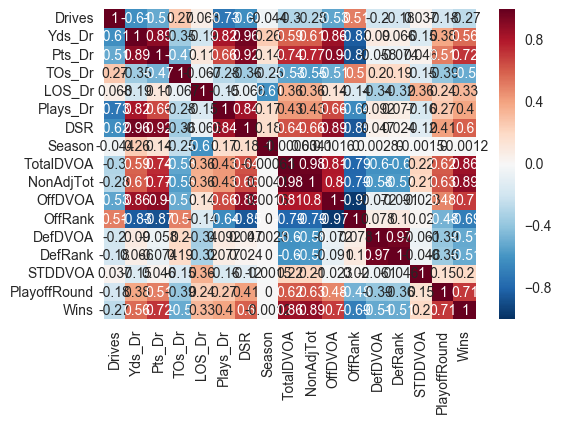

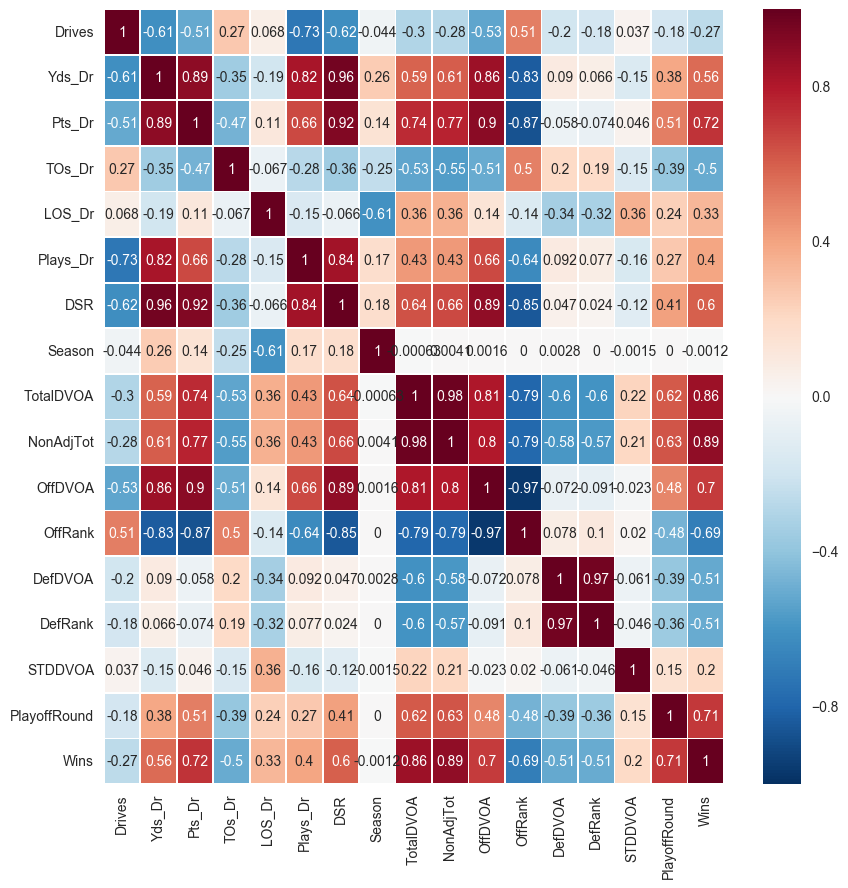

In [101]:
sns.heatmap(final.corr(), annot=True)

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(final.corr(), annot=True, linewidths=.5, ax=ax)

In [102]:
## generating matrices for linear regression
X = final.drop(['PlayoffRound','Team'],axis=1)
y = final.pop('PlayoffRound')


In [103]:
##static copies

Xstatic = X
ystatic = y

In [105]:
#raw 
ystatic, Xstatic = patsy.dmatrices('ystatic ~ Yds_Dr + Pts_Dr + TOs_Dr + LOS_Dr + Plays_Dr + DSR + TotalDVOA + NonAdjTot + OffDVOA + OffRank + DefDVOA + DefRank + STDDVOA + Wins', data=final, return_type="dataframe")
# Create your model
model = sm.OLS(ystatic, Xstatic)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ystatic   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     32.88
Date:                Thu, 02 Feb 2017   Prob (F-statistic):           2.41e-59
Time:                        14:45:38   Log-Likelihood:                -599.68
No. Observations:                 448   AIC:                             1229.
Df Residuals:                     433   BIC:                             1291.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.8917      2.391     -0.791      0.429        -6.591     2.808
Yds_Dr        -0.0157      0.050     -0.316      0.752        -0.113     0.082
Pts_Dr         0.5938      0.456      1.302      0.194        -0.303     1.491
TOs_Dr        -1.9390      1.915     -1.012      0.312        -5.704     1.826
LOS_Dr        -0.0082      0.031     -0.261      0.794        -0.070     0.053
Plays_Dr       0.0681      0.288      0.237      0.813        -0.497     0.634
DSR           -1.2897      5.546     -0.233      0.816       -12.191     9.611
TotalDVOA    -21.6615     75.829     -0.286      0.775      -170.700   127.377
NonAdjTot     -2.0356      1.303     -1.563      0.119        -4.596     0.524
OffDVOA       22.3872     75.850      0.295      0.768      -126.692   171.467
OffRank       -0.0056      0.019     -0.293      0.770        -0.044     0.032
DefDVOA      -28.5282     75.829     -0.376      0.707      -177.568   120.511
DefRank        0.0511      0.019      2.658      0.008         0.013     0.089
STDDVOA       23.1060     75.676      0.305      0.760      -125.631   171.843
Wins           0.2949      0.033      9.025      0.000         0.231     0.359
==============================================================================
Omnibus:                       97.800   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.604
Skew:                           1.196   Prob(JB):                     4.08e-42
Kurtosis:                       5.118   Cond. No.                     1.67e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [295]:
Xstatic

,Intercept,Pts_DrTrans,TOs_Dr,NonAdjTot,DefDVOA,DefRank,Wins
0,1.0,1.130295,0.098,0.261,-0.062,7.0,11.0
1,1.0,1.136441,0.079,0.238,0.140,29.0,8.0
2,1.0,0.705049,0.161,-0.036,0.077,26.0,7.0
3,1.0,0.879350,0.152,0.139,-0.004,17.0,9.0
4,1.0,0.886083,0.096,0.112,0.021,20.0,10.0
5,1.0,0.859045,0.204,-0.141,0.145,30.0,6.0
6,1.0,0.817956,0.160,-0.071,0.059,24.0,8.0
7,1.0,0.769177,0.169,-0.010,-0.006,16.0,10.0
8,1.0,0.797165,0.174,0.047,-0.053,9.0,10.0
9,1.0,0.838582,0.110,0.131,0.083,27.0,9.0


In [210]:
# Create your feature matrix (X) and target vector (y)
ystatic, Xstatic = patsy.dmatrices('ystatic ~ Pts_Dr + TOs_Dr + NonAdjTot + DefDVOA + DefRank + Wins', data=final, return_type="dataframe")
# Create your model
model = sm.OLS(ystatic, Xstatic)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ystatic   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     77.56
Date:                Thu, 02 Feb 2017   Prob (F-statistic):           6.74e-66
Time:                        16:44:10   Log-Likelihood:                -600.54
No. Observations:                 448   AIC:                             1215.
Df Residuals:                     441   BIC:                             1244.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.7528      0.608     -4.527      0.000        -3.948    -1.558
Pts_Dr         0.3884      0.249      1.562      0.119        -0.100     0.877
TOs_Dr        -2.3581      1.645     -1.433      0.152        -5.592     0.875
NonAdjTot     -1.1778      0.758     -1.554      0.121        -2.667     0.312
DefDVOA       -6.1724      1.827     -3.378      0.001        -9.763    -2.582
DefRank        0.0519      0.019      2.744      0.006         0.015     0.089
Wins           0.2947      0.032      9.319      0.000         0.233     0.357
==============================================================================
Omnibus:                       97.041   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.650
Skew:                           1.195   Prob(JB):                     2.95e-41
Kurtosis:                       5.072   Cond. No.                         866.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

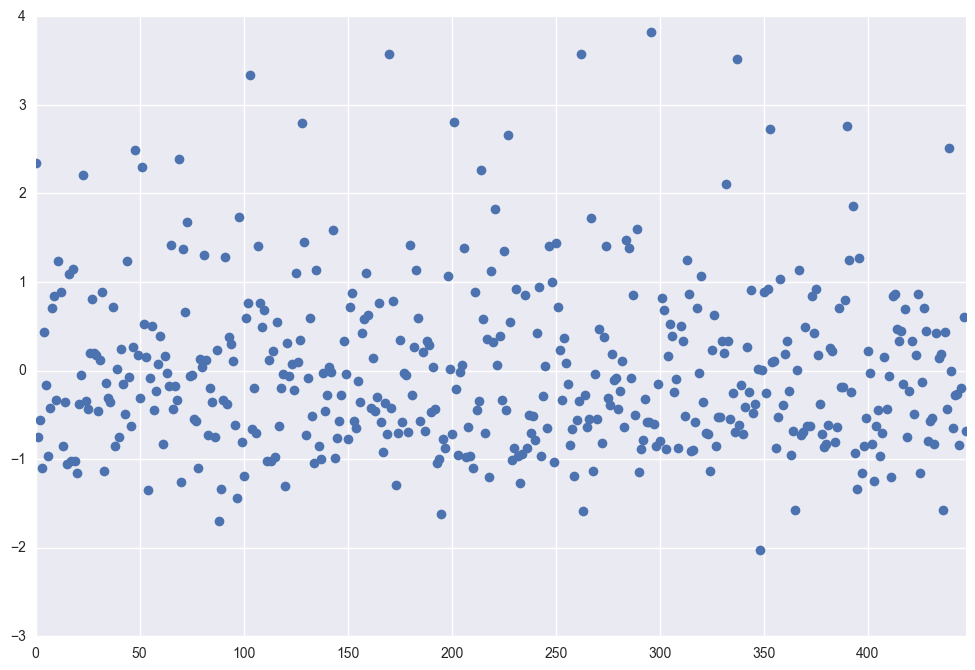

In [212]:
# Use statsmodels to plot the residuals
fit.resid.plot(style='o', figsize=(12,8))

In [224]:
lr = LinearRegression()
# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xstatic, ystatic, test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.44196134091199235

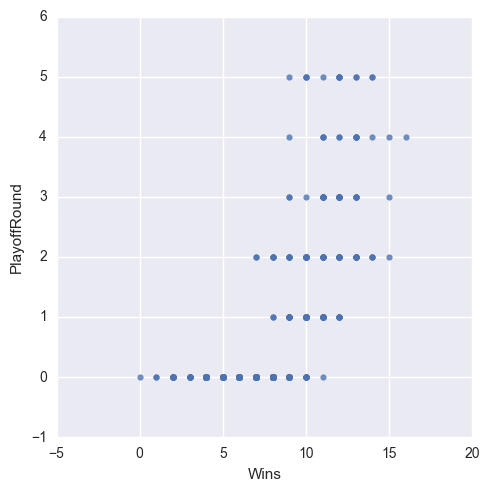

In [189]:
sns.lmplot("Wins", "PlayoffRound", data=final2, fit_reg=False)

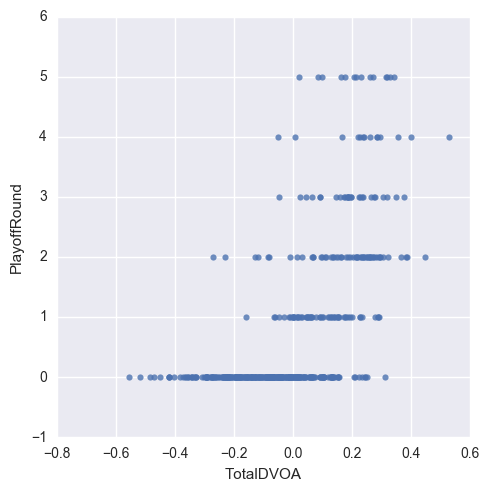

In [188]:

sns.lmplot("TotalDVOA", "PlayoffRound", data=final2, fit_reg=False)


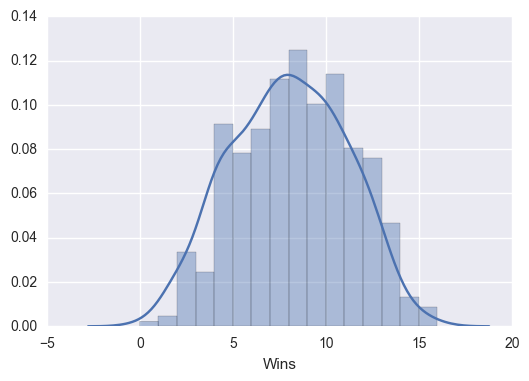

In [191]:
b = sns.distplot(final2['Wins'])

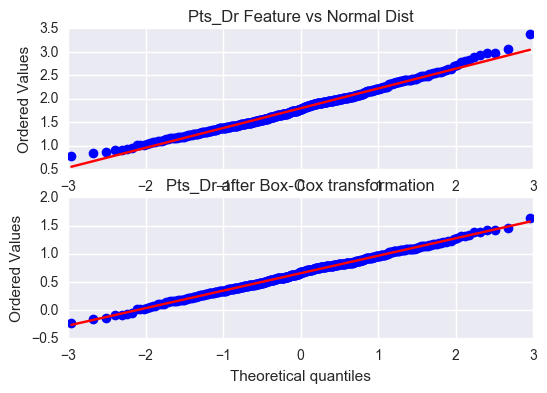

In [240]:
##examining potentinal benefit of box-cox transforms

from scipy import stats
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = final2['Pts_Dr']
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Pts_Dr Feature vs Normal Dist')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Pts_Dr after Box-Cox transformation')

In [242]:
len(xt)

448

In [243]:
final2['Pts_DrTrans'] = xt

In [245]:
# Create your feature matrix (X) and target vector (y)
ystatic, Xstatic = patsy.dmatrices('ystatic ~ Pts_DrTrans + TOs_Dr + NonAdjTot + DefDVOA + DefRank + Wins', data=final, return_type="dataframe")
# Create your model
model = sm.OLS(ystatic, Xstatic)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

##notice here, the box-cox transform doesn't improve the model. That's ok!
##if time permitted, more tinkering with the features/transforms could see an improvement


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ystatic   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     76.93
Date:                Thu, 02 Feb 2017   Prob (F-statistic):           1.69e-65
Time:                        20:26:01   Log-Likelihood:                -601.48
No. Observations:                 448   AIC:                             1217.
Df Residuals:                     441   BIC:                             1246.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      -2.2778      0.500     -4.553      0.000        -3.261    -1.295
Pts_DrTrans     0.2641      0.346      0.764      0.445        -0.415     0.943
TOs_Dr         -2.2787      1.653     -1.379      0.169        -5.527     0.969
NonAdjTot      -0.7806      0.777     -1.005      0.316        -2.308     0.747
DefDVOA        -5.6796      1.829     -3.105      0.002        -9.275    -2.085
DefRank         0.0517      0.019      2.729      0.007         0.014     0.089
Wins            0.3002      0.032      9.505      0.000         0.238     0.362
==============================================================================
Omnibus:                       97.788   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.724
Skew:                           1.202   Prob(JB):                     1.04e-41
Kurtosis:                       5.082   Cond. No.                         858.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [246]:


from sklearn.cross_validation import cross_val_score


# 10-fold cross-validation
reg = LinearRegression()
scores = cross_val_score(reg, Xstatic, ystatic, cv=10, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[ 0.74203827  0.98858051  1.03009386  0.74971497  0.99008597  1.14850914
  0.84868415  1.01817676  0.85374432  0.5840442 ]


In [278]:
##rerunning the above code to generate 2016 data

import csv
from bs4 import BeautifulSoup
from urllib2 import urlopen
link = 'http://www.footballoutsiders.com/stats/drivestatsoff'
link2 = 'http://www.footballoutsiders.com/stats/teameff'
empty = []
dfOff = pd.DataFrame(empty)
dfEff = pd.DataFrame(empty)
year = 2016
url = link
url2 = link2
soup = BeautifulSoup(urlopen(url))
soup2 = BeautifulSoup(urlopen(url2))
table = soup.find('table', attrs={ "class" : "stats"})
table2 = soup2.find('table', attrs={ "class" : "stats"})
rows = []
rows2 = []

for row in table.find_all('tr'):
    rows.append([val.text.encode('utf8') for val in row.find_all('td')])

    
for row2 in table2.find_all('tr'):
    rows2.append([val.text.encode('utf8') for val in row2.find_all('td')])
    
tempstr = ''
tempstr2 = ''
seasonTable = []
seasonTable2 = []
t = []
t2 = []
    
for row in rows:
    for item in row:
        for subitem in item:
            if subitem == ' ':
                break
            else:
                tempstr = tempstr + subitem
        t.append(tempstr)
        tempstr = ''
    seasonTable.append(t)
    t = []
        
for row2 in rows2:
    for item2 in row2:
        for subitem2 in item2:
            if subitem2 == ' ':
                break
            else:
                tempstr2 = tempstr2 + subitem2
        t2.append(tempstr2)
        tempstr2 = ''
    seasonTable2.append(t2)
    t2 = []
        
    
df = pd.DataFrame(seasonTable)
df2 = pd.DataFrame(seasonTable2)
df['season'] = 2016
df2['season'] = 2016
dfOff = dfOff.append(df)
dfEff = dfEff.append(df2)


In [279]:
##cleaning up the dataframes
dfOff.columns=['Team','Drives','Yds_Dr','Pts_Dr','TOs_Dr','INT_Dr','FUM_Dr','LOS_Dr','Plays_Dr','TOP_Dr','DSR','Season']

dfEff.columns=['na','Team','TotalDVOA','LastYr','NonAdjTot','W-L','OffDVOA','OffRank','DefDVOA','DefRank','STDDVOA','STRank','Season']

dfOff = dfOff[dfOff.Team != 'Team']
dfOff = dfOff[dfOff.Team != 'Avg']

dfEff = dfEff[dfEff.Team != '\nTEAM\n']
del dfEff['na']


In [280]:
##merging the two dataframes

dfOff.reset_index(inplace=True)
dfEff.reset_index(inplace=True)
dfMerged = pd.merge(dfOff, dfEff,
              left_on=['Team', 'Season'],
              right_on=['Team', 'Season'],
              how='inner')

In [281]:
del dfMerged['index_x']
del dfMerged['index_y']

In [282]:
dfMerged = dfMerged.drop(['INT_Dr','FUM_Dr','TOP_Dr','LastYr','STRank'], axis=1)

In [283]:
final = dfMerged

In [284]:
##maintenance on the final dataframe, converting percents to floats and swapping the w-l column for a "wins" column

import re

final['TotalDVOA'] = final['TotalDVOA'].map(lambda x: float(x.strip('%'))/100,
               na_action=None)
final['NonAdjTot'] = final['NonAdjTot'].map(lambda x: float(x.strip('%'))/100,
               na_action=None)
final['OffDVOA'] = final['OffDVOA'].map(lambda x: float(x.strip('%'))/100,
               na_action=None)
final['DefDVOA'] = final['DefDVOA'].map(lambda x: float(x.strip('%'))/100,
               na_action=None)
final['STDDVOA'] = final['STDDVOA'].map(lambda x: float(x.strip('%'))/100,
               na_action=None)
final['W-L'] = final['W-L'].map(lambda x: re.sub(r'\-.*','',x),
               na_action=None)
final['Wins'] = final['W-L']
final = final.drop('W-L',axis=1)

In [285]:
final.Drives = final.Drives.astype(float)
final.Yds_Dr = final.Yds_Dr.astype(float)
final.Pts_Dr = final.Pts_Dr.astype(float)
final.TOs_Dr = final.TOs_Dr.astype(float)
final.LOS_Dr = final.LOS_Dr.astype(float)
final.Plays_Dr = final.Plays_Dr.astype(float)
final.DSR = final.DSR.astype(float)
final.Season = final.Season.astype(int)
final.TotalDVOA = final.TotalDVOA.astype(float)
final.NonAdjTot = final.NonAdjTot.astype(float)
final.OffDVOA = final.OffDVOA.astype(float)
final.OffRank = final.OffRank.astype(int)
final.DefDVOA = final.DefDVOA.astype(float)
final.DefRank = final.DefRank.astype(int)
final.STDDVOA = final.STDDVOA.astype(float)
final.Wins = final.Wins.astype(int)


In [267]:
final.head()

,Team,Drives,Yds_Dr,Pts_Dr,TOs_Dr,LOS_Dr,Plays_Dr,DSR,Season,TotalDVOA,NonAdjTot,OffDVOA,OffRank,DefDVOA,DefRank,STDDVOA,Wins
0,ATL,166.0,40.53,3.06,0.066,28.52,6.15,0.778,2016,0.196,0.196,0.253,1,0.081,27,0.024,11
1,WAS,165.0,39.81,2.40,0.121,27.16,6.30,0.737,2016,0.092,0.051,0.161,5,0.073,25,0.004,8
2,NO,177.0,38.27,2.65,0.130,27.17,6.40,0.764,2016,-0.004,0.031,0.159,6,0.138,30,-0.026,7
3,GB,167.0,36.73,2.60,0.096,29.49,6.27,0.751,2016,0.121,0.108,0.164,4,0.024,20,-0.018,10
4,DET,152.0,35.70,2.13,0.092,25.21,6.66,0.734,2016,-0.176,-0.165,-0.010,15,0.204,32,0.037,9


In [286]:
## generating matrices for linear regression
X = final.drop(['Team'],axis=1)

In [290]:
Xf = X
Xf.head()

,Drives,Yds_Dr,Pts_Dr,TOs_Dr,LOS_Dr,Plays_Dr,DSR,Season,TotalDVOA,NonAdjTot,OffDVOA,OffRank,DefDVOA,DefRank,STDDVOA,Wins
0,166.0,40.53,3.06,0.066,28.52,6.15,0.778,2016,0.196,0.196,0.253,1,0.081,27,0.024,11
1,165.0,39.81,2.40,0.121,27.16,6.30,0.737,2016,0.092,0.051,0.161,5,0.073,25,0.004,8
2,177.0,38.27,2.65,0.130,27.17,6.40,0.764,2016,-0.004,0.031,0.159,6,0.138,30,-0.026,7
3,167.0,36.73,2.60,0.096,29.49,6.27,0.751,2016,0.121,0.108,0.164,4,0.024,20,-0.018,10
4,152.0,35.70,2.13,0.092,25.21,6.66,0.734,2016,-0.176,-0.165,-0.010,15,0.204,32,0.037,9


In [297]:
Xf.head()

,Drives,Yds_Dr,Pts_Dr,TOs_Dr,LOS_Dr,Plays_Dr,DSR,Season,TotalDVOA,NonAdjTot,OffDVOA,OffRank,DefDVOA,DefRank,STDDVOA,Wins
0,166.0,40.53,3.06,0.066,28.52,6.15,0.778,2016,0.196,0.196,0.253,1,0.081,27,0.024,11
1,165.0,39.81,2.40,0.121,27.16,6.30,0.737,2016,0.092,0.051,0.161,5,0.073,25,0.004,8
2,177.0,38.27,2.65,0.130,27.17,6.40,0.764,2016,-0.004,0.031,0.159,6,0.138,30,-0.026,7
3,167.0,36.73,2.60,0.096,29.49,6.27,0.751,2016,0.121,0.108,0.164,4,0.024,20,-0.018,10
4,152.0,35.70,2.13,0.092,25.21,6.66,0.734,2016,-0.176,-0.165,-0.010,15,0.204,32,0.037,9


In [299]:
X_test.head()

,Intercept,Pts_Dr,TOs_Dr,NonAdjTot,DefDVOA,DefRank,Wins
385,1.0,2.35,0.171,-0.017,0.131,31.0,7.0
401,1.0,1.76,0.169,-0.187,0.106,28.0,5.0
354,1.0,2.40,0.087,0.160,-0.058,10.0,11.0
196,1.0,2.02,0.175,-0.103,0.135,29.0,8.0
303,1.0,1.65,0.122,0.109,0.003,15.0,9.0


In [304]:
Xf = Xf.drop(['Drives','Yds_Dr','LOS_Dr','Plays_Dr','DSR','Season','TotalDVOA','OffDVOA','OffRank','STDDVOA'],axis=1)


In [306]:
Xf['Intercept'] = 1.0

In [316]:
cols = Xf.columns.tolist()

In [317]:
cols = cols[-1:] + cols[:-1]

In [319]:
Xf = Xf[cols]

In [328]:
Z = lr.predict(Xf)

In [344]:
for item in final['Team']:
    print item

ATL
WAS
NO
GB
DET
DAL
NE
IND
CIN
PIT
CHI
TEN
SD
BUF
SEA
KC
TB
PHI
OAK
ARI
MIN
JAC
NYJ
BAL
CAR
HOU
NYG
MIA
CLE
DEN
SF
LARM


In [346]:
predictions = []
teams = []
for i in Z:
    predictions.append(i[0])
for i in final['Team']:
    teams.append(i)

In [360]:
predictionsF = zip(teams,predictions)
print predictionsF

[('ATL', 2.1851163490351131), ('WAS', 1.094109143264768), ('NO', 0.76053032118527897), ('GB', 1.6992354763984792), ('DET', 1.0123211086295014), ('DAL', 2.4304979479442834), ('NE', 2.7805198365533497), ('IND', 0.97704769838659145), ('CIN', 0.30766169496039897), ('PIT', 1.7259648387559259), ('CHI', -0.58637984940888499), ('TEN', 1.3792239846081071), ('SD', -0.10846144939710323), ('BUF', 0.80331333128411941), ('SEA', 1.3868321457278134), ('KC', 2.0402959489328292), ('TB', 1.0897231634907159), ('PHI', 0.57880558896556122), ('OAK', 2.2674948882458765), ('ARI', 0.59946673983423837), ('MIN', 0.78884225090904847), ('JAC', -0.65561386612540673), ('NYJ', 0.089678988921543912), ('BAL', 0.7186730410056934), ('CAR', 0.2514647055674919), ('HOU', 0.97671881035969355), ('NYG', 1.687921003836315), ('MIA', 1.5406555461883227), ('CLE', -1.0986208883302298), ('DEN', 1.3245813027554756), ('SF', -0.87446299608169786), ('LARM', -0.33538151689120843)]


In [371]:
from operator import itemgetter
max(predictionsF,key=itemgetter(1))

('NE', 2.7805198365533497)